# Solving meta decision trees

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.5)
import itertools as it
from collections import Counter, defaultdict, deque
from toolz.curried import memoize, get
from random import choice
from tqdm import tqdm_notebook as tqdm

In [2]:
# Plotting decision trees
from IPython.display import display
from meta_tree import MetaTree
from IPython.display import Image
COLOR = {None: 'grey', np.inf: 'grey', 1: '#dd4444', 0: '#5555ee'}
from graphviz import Digraph
def draw_tree(state):
    dot = Digraph()
    for x, ys in enumerate(mt.tree):
        c = COLOR[state[x]]
        dot.node(str(x), style='filled', color=c)
        for y in ys:
            dot.edge(str(x), str(y))
    display(dot)

In [3]:
def sort_tree(mt, state):
    """Breaks symmetry between belief states.
    
    This is done by enforcing that the knowldge about states at each
    depth be sorted by [0, 1, UNKNOWN]
    """
    state = list(state)
    for i in range(len(mt.tree) - 1, -1, -1):
        if not mt.tree[i]:
            continue  # 
        c1, c2 = mt.tree[i]
        if not (mt.subtree(state, c1) <= mt.subtree(state, c2)):
            diff = c2 - c1
            for j in range(c1, c2):
                state[j], state[j+diff] = state[j+diff], state[j]
    return tuple(state)

def solve(mdp, hash_state=None, actions=None):
    """Returns Q, V, pi, and computation data for an mdp."""
    if actions is None:
        actions = mdp.actions
    if hash_state is None:
        hash_state = lambda s: sort_tree(mt, s)
    info = {  # track number of times each function is called
        'q': 0,
        'v': 0
    }

    @memoize
    def Q(s, a):
        info['q'] += 1
        return sum(p * (r + V(s1)) for p, s1, r in mdp.results(s, a))

    def hash_key(args, kwargs):
        s = args[0]
        if s is None:
            return s
        else:
            return hash_state(args[0])

    if hash_state is None:
        hash_key = None
        
    @memoize(key=hash_key)
    def V(s):
        if s is None:
            return 0
        info['v'] += 1
        return max(Q(s, a) for a in actions(s))
    
    @memoize
    def pi(s):
        return max(actions(s), key=lambda a: Q(s, a))
    
    return Q, V, pi, info

mt = MetaTree(2, 2, cost=-0.1)
Q, V, pi, info = solve(mt)  # note: no computation actually happens here.
print('Value:', V(mt.init))  # calling V(mt.init) runs the algorithm
print('Computations:', info)

Value: 1.80625
Computations: {'v': 171, 'q': 513}


In [4]:
def VOC1(mt, state, action):
    val_term_next = sum(p * (r + mt.term_value(s1))
        for p, s1, r in mt.results(state, action))
    return val_term_next - mt.term_value(state)

VOC1(mt, mt.init, 6)

0.1499999999999999

In [5]:
def cross(d1, d2, f):
    outcomes = Counter()
    for ((p1, o1), (p2, o2)) in it.product(d1, d2):
        outcomes[f(o1, o2)] += p1 * p2
    return [(p, v) for v, p in outcomes.items()]

def expectation(dist):
    return sum(p * v for p, v in dist)

OBS = 'OBS'
def outcomes(mt, state, n):
    d = []
    if state[n] is OBS:
        for r in mt.outcomes:
            d.append((mt.outcome_prob, r))
    elif state[n] is mt.unknown:
        d.append((1, mt.expected_outcome))
    else:
        d.append((1, state[n]))
    return d

def info_V_dist(mt, state, n):
    def rec(p, s):
        if mt.tree[s]:
            # assume 2 branch
            child_vs = [list(rec(p * 0.5, s1)) for s1 in mt.tree[s]]
            v_dist = cross(*child_vs, f=max)
            r_dist = outcomes(mt, state, s)
#             print(s, r_dist, v_dist, child_vs)
            yield from cross(r_dist, v_dist, f=lambda x, y: x+y)
        else:
            yield from outcomes(mt, state, s)
    return list(rec(1, n))

In [6]:
def VOC1(mt, state, action):
    val_term_next = sum(p * (r + mt.term_value(s1))
        for p, s1, r in mt.results(state, action))
    return val_term_next - mt.term_value(state)

def VOC1_alt(mt, state, action):
    state = list(state)
    state[action] = OBS
    state = tuple(state)
    return expectation(info_V_dist(mt, state, 0)) - mt.term_value(state)

# VOC1_alt(mt, state, 6)
def update(state, val, *nodes):
    state = list(state)
    for n in nodes:
        state[n] = val
    return tuple(state)
    
state = update(mt.init, OBS, 1)
outcomes(mt, state, 1)

[(0.5, 0), (0.5, 1)]

In [7]:
def replace(state, v1, v2, nodes=None):
    if nodes is None:
        nodes = range(len(state))
    state = list(state)
    for n in nodes:
        if state[n] == v1:
            state[n] = v2
    return tuple(state)    

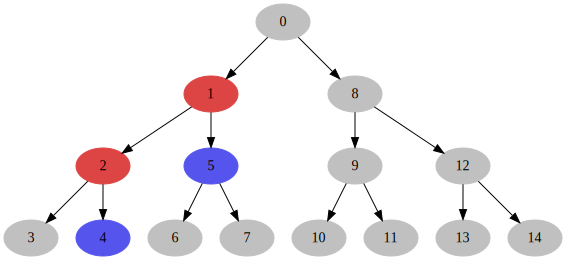

In [8]:
def VPI_action(mt, state, action):
    choices = list(mt.tree[0])
    relevant_choice = choices[0] if action < choices[1] else choices[1]
    stop = relevant_choice + choices[1] - choices[0]
    return VOI(mt, state, range(relevant_choice, stop))

def VPI_full(mt, state):
    return VOI(full, range(len(state)))

def VOI(mt, state, nodes, n=0):
    info_val = expectation(info_V_dist(mt, replace(state, mt.unknown, OBS, nodes), n))
    return info_val - mt.tree_V(state, n)

mt = MetaTree(2, 3, cost=-0.1)
state = list(mt.init)
state[1] = 1
state[2] = 1
# state[3] = 0
state[4] = 0
state[5] = 0
# state[8] = 0
state = tuple(state)
draw_tree(state)
# print(VPI_action(mt, state, 8), VPI_full(mt, state))
# print(VOC1(mt, state, s), VOC1_alt(mt, state, s))

In [9]:
def pruned_actions(mt, state):
    """Returns a subset of actions available at state.
    
    The subset is guaranteed to include an optimal action."""
    def search(i):
        if state[i] is mt.unknown and i > 0:
            yield i  # a possible computation
        if mt.tree[i]:
            c1, c2 = mt.tree[i]
            yield from search(c1)
            if mt.subtree(state, c1) != mt.subtree(state, c2):
                yield from search(c2)  # no pruning this time
    yield from search(0)
    yield mt.term_action

In [10]:
def phi(s, a):
    if a is mt.term_action:
        return ([0, 0, 0, mt.term_value(s), 0])
    else:
        return ([VOC1(mt, s, a), VPI(mt, s), VPI_action(mt, s, a), mt.term_value(s), mt.cost])

In [12]:
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
# to_categorical(y, num_classes=None)

Using TensorFlow backend.


In [13]:
def encode(mt, state):
    x = [{np.inf: mt.term_action}.get(v, v) for v in state]
    return to_categorical(x, num_classes=mt.term_action+1).ravel()


In [14]:
encode(mt, mt.init)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0

In [44]:
model = Sequential([
    Dense(60, input_shape=encode(mt, mt.init).shape, activation='relu'),
    Dense(40, activation='relu'),
    Dense(20, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1, activation='linear')
])
model.compile(optimizer='rmsprop', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                3420      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 6,901
Trainable params: 6,901
Non-trainable params: 0
_________________________________________________________________


In [45]:
mt = MetaTree(2, 3, cost=-0.1)
Q, V, pi, info = solve(mt)

for _ in range(100):
    states, actions, r = run_episode(mt, pi)
    X = np.stack([encode(mt, s) for s in states[:-1]])
    y = np.array([V(s) for s in states[:-1]]).reshape(-1, 1)
    model.fit(X, y, epochs=1)

Epoch 1/1
4/4 [==============================] - 0s - loss: 3.9429
Epoch 1/1
3/3 [==============================] - 0s - loss: 3.3333
Epoch 1/1
3/3 [==============================] - 0s - loss: 1.8741
Epoch 1/1
6/6 [==============================] - 0s - loss: 2.8794
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.1913
Epoch 1/1
3/3 [==============================] - 0s - loss: 2.0469
Epoch 1/1
3/3 [==============================] - 0s - loss: 0.9303
Epoch 1/1
3/3 [==============================] - 0s - loss: 0.7380
Epoch 1/1
3/3 [==============================] - 0s - loss: 1.2851
Epoch 1/1
3/3 [==============================] - 0s - loss: 0.9837
Epoch 1/1
4/4 [==============================] - 0s - loss: 0.9008
Epoch 1/1
3/3 [==============================] - 0s - loss: 0.2413
Epoch 1/1
6/6 [==============================] - 0s - loss: 1.1335
Epoch 1/1
5/5 [==============================] - 0s - loss: 0.0628
Epoch 1/1
5/5 [==============================] - 0s - loss: 0.

In [72]:
X[0, 0] = np.nan

In [73]:
states, actions, r = run_episode(mt, pi)
X = np.stack([encode(mt, s) for s in states[:-1]])
y = np.array([V(s) for s in states[:-1]]).reshape(-1, 1)
model.test_on_batch(X, y)

0.013494061

In [14]:
def run_episode(mt, pi, s=None):
    """Runs a single random episode with policy pi."""
    if s is None:
        s = mt.init
    states = [s]
    acts = []
    reward = 0
    while True:
        s0 = states[-1]
        a = pi(s0)
        p, s1, r = choice(mt.results(s0, a))
        acts.append(a)
        states.append(s1)
        reward += r
        if a == mt.term_action:
#             draw_tree(states[-1])
            return states, acts, reward

# def run_many(mt, pi, N=1000):
#     for _ in range(N):
#         reward = run_episode(mt, pi)[-1]
#         yield reward 

run_episode(mt, pi)

KeyboardInterrupt: 

In [ ]:
mt = MetaTree(2, 3, outcomes=(0,1), cost=-0.1)
Q, V, pi, info = solve(mt)
all_states = it.product((mt.unknown, *mt.outcomes), repeat=len(mt.tree))
all_states = list(all_states)
V(mt.init)

2.4860839843749996

In [ ]:
X = np.stack([encode(mt, s) for s in all_states])
y = np.array([V(s) for s in all_states]).reshape(-1, 1)
model.fit(X, y, validation_split=0.5, batch_size=5, epochs=10)

In [74]:
def rms(y_hat, y):
    return ((y_hat - y) ** 2).mean() ** 0.5
y = np.array(Q_star)
X = np.array(features)
pi_hat = np.array(pi_hat)
pi_mat = np.array(pi_mat)

beta = np.linalg.inv(X.T @ X) @ X.T @ y
y_hat = X @ beta

print(beta)
print(rms(y_hat, y))
print(rms(y.mean(), y))
print((pi_hat == pi_mat).mean())

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

In [13]:


from toolz import curry
@curry
def mat_pi(pi_mat, s):
    i = state_labeler(sort_tree(mt, s))
    return pi_mat[i]
    # dd = df.query('state == @s')
    # return dd.action[dd.y_hat.argmax()]

@curry
def Q_hat(s, a):
    x = phi(s, a)
    return x @ beta

def pi_hat2(s):
    return max((a for a in mt.actions(s)), key=Q_hat(s))

# # hat_returns = pd.Series(run_many(mt, pi_hat2, N=5000))
# # opt_returns = pd.Series(run_many(mt, pi, N=5000))
# sns.distplot(hat_returns, label='approx  {:.2f}'.format(hat_returns.mean()),kde=0)
# sns.distplot(opt_returns, label='optimal  {:.2f}'.format(opt_returns.mean()),kde=0)
# plt.legend(frameon=True)
# plt.title('5000 returns on height-3 binary tree.')
# plt.xlim(0, 4)
# # draw_tree(S)
# # Q_hat(mt.init, 8)
# # print(phi(mt.init, 8))
# # print(phi(mt.init, 1))

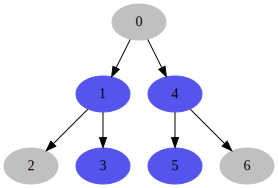

In [107]:
draw_tree((inf, 0, inf, 0, 0, 0, inf))


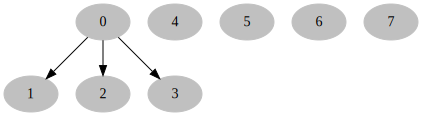

In [129]:
mt = MetaTree(3, 1)
draw_tree(mt.init)